In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from read_gmsh4 import readGmsh4

In [2]:
# definition d'un objet element

class Node:
    id = 0
    def __init__(self, x, y, region):
        self.id = Node.id
        Node.id += 1
        self.x = x
        self.y = y
        self.region = region
        
    def __repr__(self):
        return f"Node {self.id} [{self.x},{self.y}], region = {self.region}"

class Element:
    id = 0
    def __init__(self, nodes):
        self.nodes = nodes
        self.id = Element.id
        Element.id += 1
        
    def getCoords(self):
        return np.array([[n.x,n.y] for n in self.nodes])
    
    def __repr__(self):
        return f"Element {self.id}\nNodes : {[n.id for n in self.nodes]}\nCoords : {self.getCoords()}"

def plotMesh(elements, nodes, regions = []):
    
    fig, ax = plt.subplots()
    
    regionsSymbols = ["+b", "+r", "+g", "+y"]
    
    for e in elements:
        coords = e.getCoords()
        plt.fill(coords[:,0], coords[:,1], color="greenyellow", alpha=0.5, ec="k")
        
    for (i,r) in enumerate(regions):
        for n in nodes:
            if n.region == r: plt.plot(n.x, n.y, regionsSymbols[i%4])
            
    ax.set_aspect("equal", "box")
    plt.show()

In [3]:
# definition du maillage

Node.id = 0
Element.id = 0

N = 10
L = 100.0
xCoords = np.linspace(0.0, L, N+1)
dof = (N+1)*(N+1)

# regions index
omega, bot, right, top, left = 1, 2, 3, 4, 5
Ttop, Tbot = 10.0, 30.0

nodesCoord = np.array([[[x,y] for x in xCoords] for y in xCoords]).reshape((dof,2))
nodes = [Node(coord[0], coord[1], 2 if coord[1] == 0.0 else 1) for coord in nodesCoord]

elements = []
for i in range(N*N):
    nodesIdx = [i+i//N,i+1+i//N,i+N+2+i//N,i+N+1+i//N]
    elements.append(Element([nodes[n] for n in nodesIdx]))

In [3]:
# chargement d'un maillage

Node.id = 0
Element.id = 0

file = "../meshes/t2.msh"
    
regions = [
        (1, 1),
        (1, 2)
        ]
    
elements, nodes = readGmsh4(file, regions) 
dof = len(nodes)

[Element 1
Nodes : [1788, 86, 87, 1787]
Coords : [[6.49670762 0.10086606]
 [6.47096774 0.        ]
 [6.58064516 0.        ]
 [6.60546438 0.10097851]]
, Element 2
Nodes : [1789, 1786, 318, 319]
Coords : [[6.49674528 9.09916598]
 [6.60546426 9.0990213 ]
 [6.58064516 9.2       ]
 [6.47096774 9.2       ]]
, Element 3
Nodes : [1754, 223, 224, 1747]
Coords : [[0.1008897  6.87488099]
 [0.         6.9       ]
 [0.         6.79047619]
 [0.10099728 6.76658372]]
, Element 4
Nodes : [1755, 140, 141, 1751]
Coords : [[10.09911025  2.27488078]
 [10.2         2.3       ]
 [10.2         2.40952381]
 [10.09883944  2.38482036]]
, Element 5
Nodes : [1753, 265, 266, 1750]
Coords : [[0.10088977 2.2748808 ]
 [0.         2.3       ]
 [0.         2.19047619]
 [0.10099758 2.16658279]]
, Element 6
Nodes : [1752, 182, 183, 1745]
Coords : [[10.09911027  6.92511922]
 [10.2         6.9       ]
 [10.2         7.00952381]
 [10.09900243  7.03341721]]
, Element 7
Nodes : [1752, 1744, 181, 182]
Coords : [[10.09911027  6.

Element 0
Nodes : [0, 1, 12, 11]
Coords : [[ 0.  0.]
 [10.  0.]
 [10. 10.]
 [ 0. 10.]]
Node 0 [0.0,0.0], region = 2
Node 1 [10.0,0.0], region = 2


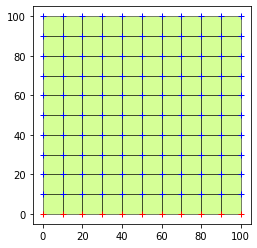

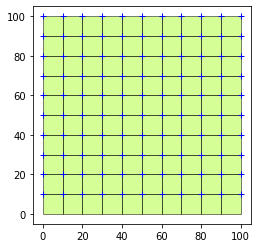

In [4]:
print(elements[0])
print(elements[0].nodes[0])
print(elements[0].nodes[1])
plotMesh(elements, nodes, [1,2]) #region 2 for down boundary
plotMesh(elements, nodes, [1,3]) #region 3 for all other boundaries

In [5]:
# définition des interpolateurs (P1 : linéaire) et de ses dérivées partielles

Nelem = 4

phi = [
    lambda u,v : 0.25*(1-u)*(1-v), # (-1,-1)
    lambda u,v : 0.25*(1+u)*(1-v), # (+1,-1)
    lambda u,v : 0.25*(1+u)*(1+v), # (+1,+1)
    lambda u,v : 0.25*(1-u)*(1+v), # (-1,+1)
]

duphi = [
        lambda u,v : -0.25*(1-v),   # (-1,-1)
        lambda u,v : 0.25*(1-v),    # (+1,-1)
        lambda u,v : 0.25*(1+v),   # (-1,+1)
        lambda u,v : -0.25*(1+v),   # (+1,+1)
]
dvphi = [
        lambda u,v : -0.25*(1-u),   # (-1,-1)
        lambda u,v : -0.25*(1+u),   # (+1,-1)
        lambda u,v : 0.25*(1+u),    # (-1,+1)
        lambda u,v : 0.25*(1-u),    # (+1,+1)
]

gradphi = [
        lambda u,v: np.array([duphi[i](u,v), dvphi[i](u,v)])
        for i in range(4)
]

# fonction retournant l'interpolateur selon les 4 fonctions phi pour les 4 valeurs aux noeuds X
def interp(phiList, X):
    return lambda u,v : sum([phi(u,v)*x for phi,x in zip(phiList, X)])

In [6]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne

for e in elements:

    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    e.detJ = lambda u,v : dxdu(u,v)*dydv(u,v) - dxdv(u,v)*dydu(u,v)

    e.iJ = lambda u,v :  np.array(
        [[dydv(u,v), -dydu(u,v)],
        [-dxdv(u,v), dxdu(u,v)]]
    )/e.detJ(u,v)

In [7]:
# Détermination d'une règle de quadrature 

# nombre de points de quadrature (par dimension)
Nquad = 6

# importation poids et abscices Gauss-Legendre
data = np.loadtxt(f"../quadratureRules/gl_{Nquad:02d}.tab")
w_i, xi_i = data[:,0], data[:,1] 

# Compute the 2D integral of f(u,v) over [-1,1]x[-1,1]

int2D = lambda f: sum([ sum([w1*w2 * f(xi1, xi2) for xi1,w1 in zip(xi_i, w_i)]) for xi2,w2 in zip(xi_i, w_i)])

In [8]:
# Détermination des coefficients de Lamé

# pour du béton en compression
Young = 11
Poisson = 0.15

lambda_coef = (Young*Poisson) / ((1+Poisson)*(1-2*Poisson))
mu_coef = Young / (2*(1+Poisson))

D = np.array([[lambda_coef + 2*mu_coef, lambda_coef, 0], [lambda_coef, lambda_coef + 2*mu_coef, 0], [0, 0, mu_coef]])
D

array([[11.61490683,  2.04968944,  0.        ],
       [ 2.04968944, 11.61490683,  0.        ],
       [ 0.        ,  0.        ,  4.7826087 ]])

In [9]:
# Détermination des matrices pour l'élasticité

for e in tqdm(elements):
    
    BN1, BN2, BN3 = [], [], []
    for a in range(Nelem):
        BN1.extend([lambda u,v: e.iJ(u,v)[0,:]@gradphi[a](u,v), lambda u,v: 0])
        BN2.extend([lambda u,v: 0, lambda u,v: e.iJ(u,v)[1,:]@gradphi[a](u,v)])
        BN3.extend([lambda u,v: e.iJ(u,v)[0,:]@gradphi[a](u,v)/2, lambda u,v: e.iJ(u,v)[1,:]@gradphi[a](u,v)/2])
    e.BN = np.array([BN1, BN2, BN3], dtype=object)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 25000.32it/s]


In [8]:
elements[4].BN.transpose().shape

(8, 3)

In [10]:
# Calcul des matrices élémentaires locales -> à optimiser

for e in tqdm(elements):

    e.Ke = np.zeros((8,8))
    
    for i in range(8):
        for j in range(8):

            fk = lambda u,v: sum(sum( e.BN.transpose()[i,k](u,v) * D[k,h] * e.BN[h,j](u,v) *e.detJ(u,v) for k in range(3)) for h in range(3))
            e.Ke[i,j] = int2D(fk)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


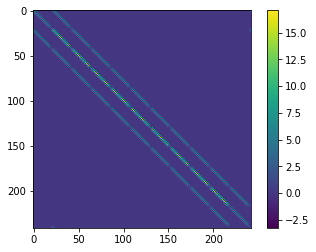

In [32]:
# Calcule des matrices globales -> à optimiser
K = np.zeros((2*dof,2*dof))

for e in elements:
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            
            K[2*(n1.id-1),2*(n2.id-1)] += e.Ke[2*i,2*j]
            K[2*(n1.id-1),2*(n2.id-1)+1] += e.Ke[2*i,2*j+1]
            K[2*(n1.id-1)+1,2*(n2.id-1)] += e.Ke[2*i+1,2*j]
            K[2*(n1.id-1)+1,2*(n2.id-1)+1] += e.Ke[2*i+1,2*j+1]

plt.imshow(K)
plt.colorbar()

<IPython.core.display.Javascript object>


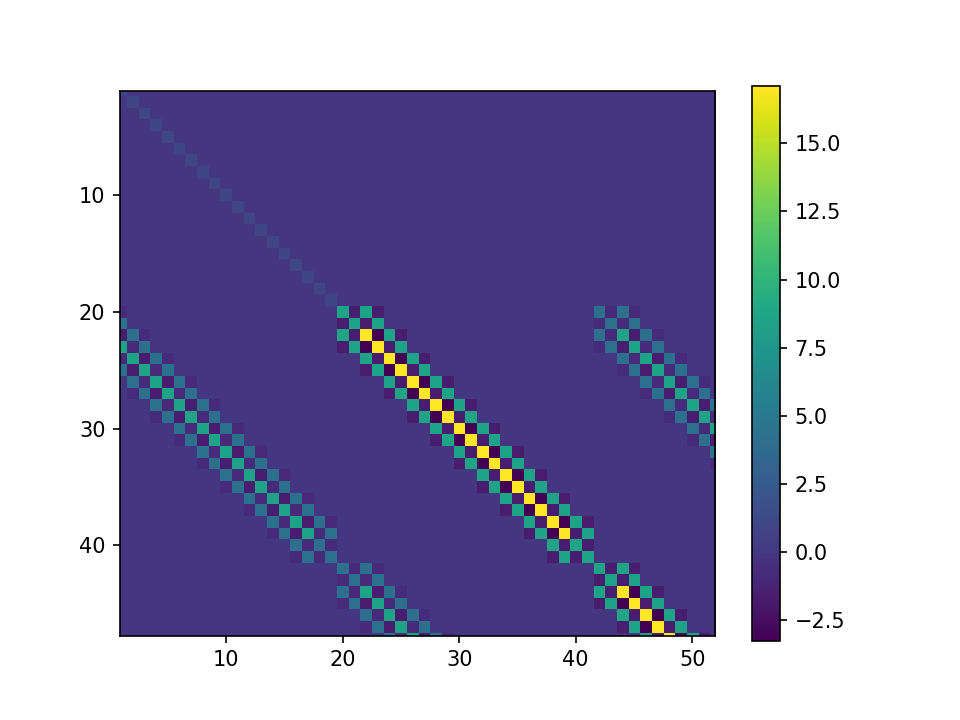

In [38]:
# Conditions aux limites

F = np.zeros(2*dof)
boundary = 2
boundary_list = []
shift = [0.1, 0]

for n in nodes:
    if n.region == boundary:
        K[2*(n.id-1),:] = 0
        K[2*(n.id-1)+1,:] = 0
        K[2*(n.id-1), 2*(n.id-1)] = 1
        K[2*(n.id-1)+1, 2*(n.id-1)+1] = 1
        F[2*(n.id-1)] = shift[0]
        F[2*(n.id-1)+1] = shift[1]

%matplotlib notebook
plt.imshow(K)
plt.colorbar()
plt.show()

In [34]:
# Résolution du système

U = np.linalg.solve(K, F)

LinAlgError: Singular matrix

In [25]:
print(U)

[ 4.54978517e+15  5.06827749e+13 -3.73348057e+15 -4.26304495e+14
  3.70347061e+15  1.50784294e+15 -4.24589406e+15 -1.49465638e+15
  4.46246061e+15  3.75179788e+14 -4.00272226e+15 -3.62986284e+14
  4.46058798e+15  8.25656356e+14 -3.81286673e+15 -4.23123740e+14
  4.02398129e+15  7.57587458e+14 -4.38670249e+15 -1.62457705e+15
 -1.27900348e+15 -4.56874132e+14  1.22800657e+15  4.53165904e+14
 -2.04431116e+15 -7.75441831e+13  2.07432112e+15 -1.00399427e+15
 -1.53189768e+15  9.90807698e+14  1.31533113e+15  1.28668891e+14
 -1.77506948e+15 -1.40862395e+14  1.31720376e+15 -3.21807678e+14
 -1.96492501e+15 -8.07249381e+13  1.75381045e+15 -2.53738779e+14
 -1.39108925e+15  1.12072838e+15 -2.53798033e+14  2.32634682e+15
  3.04794950e+14 -2.32263859e+15  5.11509645e+14  1.94701687e+15
 -5.41519606e+14 -8.65478422e+14 -9.03839480e+11  8.78664990e+14
  2.17470391e+14 -1.99814158e+15  2.42267963e+14  2.01033508e+15
  2.15597756e+14 -1.54766501e+15  4.32123489e+14  1.95019763e+15
 -2.21008930e+14 -1.61573

In [22]:
def plotNodesValues(U, nodes, ax):
    dots = ax.scatter([n.x + U[2*(n.id-1)] for n in nodes], [n.y + U[2*(n.id-1)+1] for n in nodes], c=np.sqrt(U[::2]**2 + U[1::2]**2), zorder=5)
    plt.colorbar(dots)
    ax.set_aspect("equal", "box")
    
def plotMeshLimits(elements, ax):
    for e in elements:
        coords = e.getCoords()
        ax.fill(coords[:,0], coords[:,1], facecolor="none", ec="k", zorder=1)

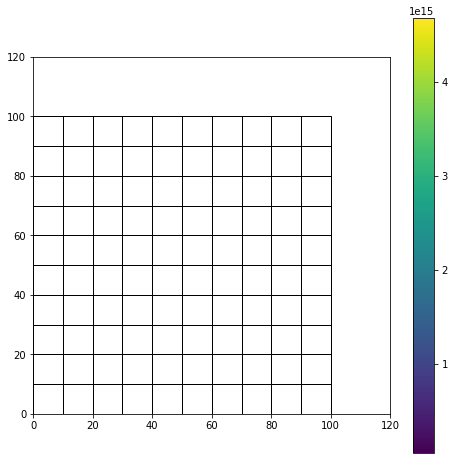

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_ylim(0,120)
ax.set_xlim(0,120)

plotNodesValues(U, nodes, ax)
plotMeshLimits(elements, ax)

In [28]:
def plotBourrin(U, elements, ax, mesh=False):
        
    u = np.linspace(-1, 1, 10)
    uu, vv = np.meshgrid(u,u)
    
    vmin, vmax = U.min(), U.max()
    
    for e in elements:
        
        coords = e.getCoords()
        X, Y = coords[:,0], coords[:,1]
        
        zitp = interp(phi, [U[n.id] for n in e.nodes])
        xitp = interp(phi, X)
        yitp = interp(phi, Y)
        
        Z = zitp(uu, vv)
        X = xitp(uu, vv)
        Y = yitp(uu, vv)
        
        dots = plt.scatter(X, Y, marker=",", c = Z, vmin=vmin, vmax=vmax)
    
    plt.colorbar(dots)
    
    if mesh:
        for e in elements:
            n1,n2,n3,n4 = e.nodes        
            plt.plot([n1.x,n2.x], [n1.y,n2.y], "k", lw=0.5)
            plt.plot([n2.x,n3.x], [n2.y,n3.y], "k", lw=0.5)
            plt.plot([n3.x,n4.x], [n3.y,n4.y], "k", lw=0.5)
            plt.plot([n4.x,n1.x], [n4.y,n1.y], "k", lw=0.5)
    
    ax.set_aspect("equal", "box")        

ValueError: operands could not be broadcast together with shapes (10,10) (2,) 

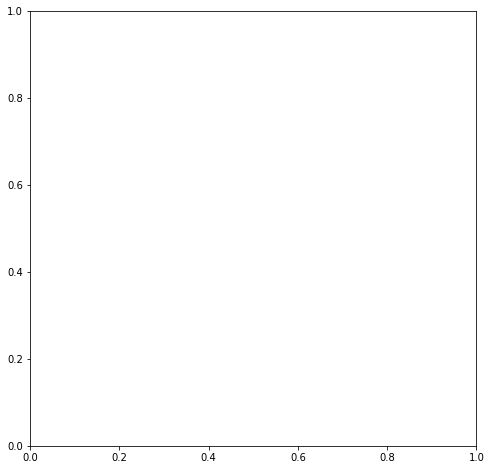

In [29]:
fig, ax = plt.subplots(figsize=(8,8))

plotBourrin(U, elements, ax)
plotMeshLimits(elements, ax)

ValueError: z array must have same length as triangulation x and y arrays

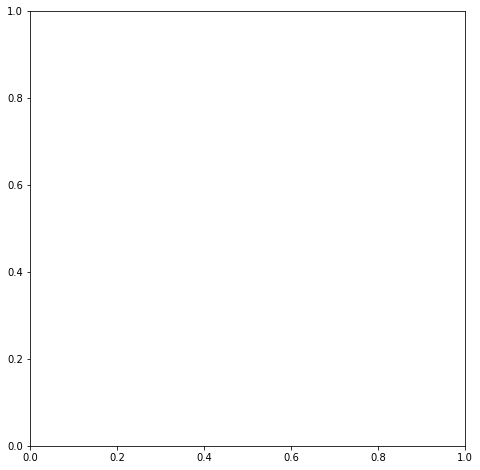

In [24]:
def quad2tri(e):
    n0, n1, n2, n3 = e.nodes
    return Element([n0, n1, n2]), Element([n2, n3, n0])

def plotFemResults(nodes, elements, U, ax):
    
    ax.set_aspect("equal", "box")        
    
    X = np.array([n.x for n in nodes])
    Y = np.array([n.y for n in nodes])
    elmtNodes = np.array([[n.id for n in e.nodes] for e in elements])
    levels = np.linspace(U.min(), U.max(), 100)
    
    im = ax.tricontourf(X, Y, elmtNodes, U, levels=levels) 
    plt.colorbar(im)

elementsTri = []
for e in elements:
    e1, e2 = quad2tri(e)
    elementsTri.append(e1)
    elementsTri.append(e2)


fig,ax = plt.subplots(figsize=(8,8))

plotFemResults(nodes, elementsTri, U, ax) 
plotMeshLimits(elements, ax)   